### PAR-2(GCN4) in cells with abolished cortical flows (Part 2)

As before, but plotting quantification

Dependencies:
- Relies on quantification data generated by _Run/mlc4_quantify.ipynb_


In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
sys.path.append('../../..')
from src import bounded_mean_1d, raw_data_path
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

if not os.path.exists('Figs'):
    os.mkdir('Figs')

### Analysis functions

In [2]:
def peak_conc(m):
    max_conc = -999999999999
    min_conc = 9999999999
    max_diff = -99999999
    for i in range(len(m)):
        max_conc = max([max_conc, bounded_mean_1d(np.roll(m, i), [0, 0.2])])
        min_conc = min([min_conc, bounded_mean_1d(np.roll(m, i), [0, 0.2])])
        max_diff = max(
            [
                max_diff,
                bounded_mean_1d(np.roll(m, i), [0, 0.2])
                - bounded_mean_1d(np.roll(m, i + len(m) // 2), [0, 0.2]),
            ]
        )
    return max_conc / 1000

### mlc-4 timelapse data

In [3]:
# Import data
res_mlc4 = pd.read_csv("../../../data/mlc4_quantification_no_pb.csv")
df_mlc4 = pd.read_csv("../../../data/mlc4_embryos.csv")
if raw_data_path:
    df_mlc4["Path"] = df_mlc4["Path"].apply(lambda x: raw_data_path + x)

### Wild type data

In [4]:
df = pd.read_csv("../../../data/par2_nebd_embryos.csv")
if raw_data_path:
    df["Path"] = df["Path"].apply(lambda x: raw_data_path + x)
df_quantification = pd.read_csv("../../../data/par2_nebd_quantification.csv")
df_quantification_grouped = df_quantification.groupby("EmbryoID")

_dfs = []
for i, r in df_quantification_grouped:
    cyt = np.mean(r["Cytoplasmic signal"])
    mem_tot = np.mean(r["Membrane signal"])
    mem_ant = bounded_mean_1d(r["Membrane signal"], [0.4, 0.6])
    mem_post = bounded_mean_1d(r["Membrane signal"], [0.9, 0.1])
    m = r["Membrane signal"].to_numpy()
    max_conc = peak_conc(m)

    p = {
        "EmbryoID": i,
        "Cyt": cyt,
        "Mem_tot": mem_tot,
        "Mem_ant": mem_ant,
        "Mem_post": mem_post,
        "Max conc": max_conc,
    }
    _dfs.append(pd.DataFrame(p, index=[i]))
df_summary = pd.concat(_dfs)
df = pd.merge(df, df_summary, on="EmbryoID")

# Filter
df = df[df.RNAi == "wt"]

# Get average peak concentration by line
wt_data_by_line = df.groupby("Line").apply(lambda x: np.mean(x["Max conc"])).to_dict()

### Plotting functions

In [5]:
def plot_membrane_conc(ax, embryoID):
    path = df_mlc4[df_mlc4.EmbryoID == embryoID].Path.iloc[0]
    mems = [
        i["Membrane signal"].to_numpy()
        for (_, i) in res_mlc4[res_mlc4.EmbryoID == embryoID].groupby("Frame")
    ]
    cyts = [
        i["Cytoplasmic signal"].to_numpy()
        for (_, i) in res_mlc4[res_mlc4.EmbryoID == embryoID].groupby("Frame")
    ]

    mems_peak = [peak_conc(_m) for _m, _c in zip(mems, cyts)]
    nebd = np.loadtxt(path + "/NEBD.txt") - 1
    x = np.arange(-nebd, len(mems) - nebd) / 2
    if x[0] < 0:
        print(embryoID, mems_peak[-1])
        ax.plot(x, mems_peak, linewidth=1)


def full_figure(line):
    embryoIDs = df_mlc4[df_mlc4.Line == line].EmbryoID

    fig, ax = plt.subplots()
    for e in embryoIDs:
        plot_membrane_conc(ax, e)

    ax.set_xlim(-5, 5)
    ax.tick_params(axis="both", labelsize=8)
    ax.set_xlabel("Time (minutes from NEBD)", fontsize=9)
    ax.set_ylabel("Peak membrane\nconcentration\n(a.u.)", fontsize=8)
    ax.set_ylim(bottom=0, top=45)
    fig.set_size_inches(2.5, 1.5)
    fig.subplots_adjust(bottom=0.3, left=0.27)
    return fig, ax

### Figures

1651762677 43.87832201020408


1651764081 31.142399057142857


1651763515 29.11864134259259


1651765978 18.179152085714286


1651768497 18.777468887850468


/var/folders/5j/5w7z2nk175b1p49dkvtcty78p4qhzw/T/ipykernel_85730/1971222622.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["", "", "", "", ""])


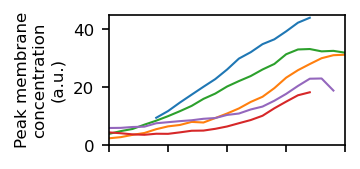

In [6]:
if raw_data_path:
    fig, ax = full_figure("lp637")
    ax.set_xlabel("")
    ax.set_xticklabels(["", "", "", "", ""])
    fig.savefig("Figs/timelapse_quantification_wt.png", dpi=600, transparent=True)

1651686192 8.119123057692308


1651689529 10.01958341981132


1651690158 14.390460014705878


1651691673 3.6391003923076926


1651692142 7.441867627184466


1651758810 18.500810848623853


1651759099 8.95019623367347


1651761419 8.130891977669904


1651761965 9.892032285858585


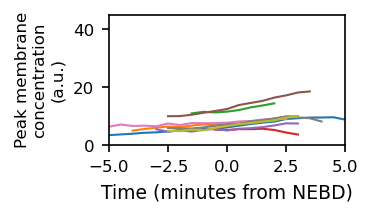

In [7]:
if raw_data_path:
    fig, ax = full_figure("nwg376")
    fig.savefig("Figs/timelapse_quantification_gcn4.png", dpi=600, transparent=True)